# XGBoost Most Important

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt 
import seaborn as sns
import ppscore as pps

## Read in and Split Data

In [2]:
# read in data
data = pd.read_csv('../data/business_closures_data.csv')
data.head()

,merchants_all,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% Below Poverty,Median Household Income,% No College Degree,Unemployment Rate,% Not in Labor Force,% Jobs in Leisure and Hospitality,% Part-time,% Self-Employed,Presence of Water Violation (dummy Y/N),Other Primary Care Provider Ratio (:1)
0,-0.3970,19089,Iowa,Howard,99,5608.073753,12.622644,3.160173,3.574778,6.971154,...,9.6,58028.0,11.560510,2.8,26.448363,5.143541,31.287879,16.264805,0,1021
1,-0.0101,31177,Nebraska,Washington,195,4632.870334,11.720313,2.750393,3.175809,6.013514,...,6.8,75197.0,21.067497,2.9,29.484214,6.721927,32.813006,12.265953,0,1148
2,-0.0551,31159,Nebraska,Seward,207,5410.847151,12.026406,2.968235,3.218111,6.212121,...,7.2,72291.0,19.126991,2.9,34.388775,7.529180,33.000000,11.688027,0,4330
3,-0.0159,31145,Nebraska,Red Willow,137,6658.414878,14.776613,3.288232,3.690134,6.571742,...,12.0,50260.0,11.779891,2.8,32.797243,11.402280,34.854962,16.237970,0,825
4,-0.1920,31141,Nebraska,Platte,309,5279.823593,14.422556,3.001068,3.286868,5.771531,...,9.0,62804.0,14.510795,2.9,30.711008,7.532143,31.196560,10.707512,1,2085


In [3]:
X = data.drop(["FIPS", "merchants_all", "State", "County"], axis=1)
y = pd.DataFrame(data["merchants_all"])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
len(X.columns)

98

## XGBoost and Feature Importance

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
"""
Hyperparameter Tuning from 
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
"""

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':"rmse"
}

In [10]:
num_boost_round = 999

In [11]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:0.58582
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.42724
[2]	Test-rmse:0.31854
[3]	Test-rmse:0.24525
[4]	Test-rmse:0.19778
[5]	Test-rmse:0.16842
[6]	Test-rmse:0.15071
[7]	Test-rmse:0.14042
[8]	Test-rmse:0.13465
[9]	Test-rmse:0.13151
[10]	Test-rmse:0.12969
[11]	Test-rmse:0.12852
[12]	Test-rmse:0.12830
[13]	Test-rmse:0.12784
[14]	Test-rmse:0.12806
[15]	Test-rmse:0.12765
[16]	Test-rmse:0.12736
[17]	Test-rmse:0.12740
[18]	Test-rmse:0.12710
[19]	Test-rmse:0.12690
[20]	Test-rmse:0.12734
[21]	Test-rmse:0.12707
[22]	Test-rmse:0.12701
[23]	Test-rmse:0.12692
[24]	Test-rmse:0.12645
[25]	Test-rmse:0.12695
[26]	Test-rmse:0.12736
[27]	Test-rmse:0.12693
[28]	Test-rmse:0.12699
[29]	Test-rmse:0.12721
[30]	Test-rmse:0.12709
[31]	Test-rmse:0.12700
[32]	Test-rmse:0.12698
[33]	Test-rmse:0.12709
[34]	Test-rmse:0.12730
Stopping. Best iteration:
[24]	Test-rmse:0.12645



In [12]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.568128,0.001370,0.568794,0.008470
1,0.407677,0.001089,0.410756,0.008493
2,0.297741,0.001030,0.303945,0.009392
3,0.222822,0.001307,0.234168,0.008905
4,0.171971,0.001492,0.191075,0.008847
5,0.138070,0.002678,0.164495,0.008310
6,0.115092,0.002642,0.150249,0.007562
7,0.101125,0.002544,0.141974,0.006230
8,0.090766,0.003545,0.138046,0.005901
9,0.083696,0.003645,0.136374,0.005954


In [13]:
cv_results['test-rmse-mean'].min()

0.1338056

### Tune max_depth and min_child_weight

In [14]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [15]:
# Define initial best params and rmse
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=9, min_child_weight=5
	rmse 0.1384732 for 12 rounds
CV with max_depth=9, min_child_weight=6
	rmse 0.1376054 for 12 rounds
CV with max_depth=9, min_child_weight=7
	rmse 0.1324144 for 12 rounds
CV with max_depth=10, min_child_weight=5
	rmse 0.1388824 for 13 rounds
CV with max_depth=10, min_child_weight=6
	rmse 0.13577080000000002 for 15 rounds
CV with max_depth=10, min_child_weight=7
	rmse 0.13346560000000002 for 12 rounds
CV with max_depth=11, min_child_weight=5
	rmse 0.1367388 for 24 rounds
CV with max_depth=11, min_child_weight=6
	rmse 0.1349696 for 14 rounds
CV with max_depth=11, min_child_weight=7
	rmse 0.1339236 for 22 rounds
Best params: 9, 7, rmse: 0.1324144


In [16]:
params['max_depth'] = 9
params['min_child_weight'] = 7

### Tune subsample and colsample

In [17]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [18]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	rmse 0.1324144 for 12 rounds
CV with subsample=1.0, colsample=0.9
	rmse 0.1349048 for 14 rounds
CV with subsample=1.0, colsample=0.8
	rmse 0.13433520000000002 for 15 rounds
CV with subsample=1.0, colsample=0.7
	rmse 0.1382642 for 10 rounds
CV with subsample=0.9, colsample=1.0
	rmse 0.1372672 for 13 rounds
CV with subsample=0.9, colsample=0.9
	rmse 0.1368474 for 17 rounds
CV with subsample=0.9, colsample=0.8
	rmse 0.1350892 for 12 rounds
CV with subsample=0.9, colsample=0.7
	rmse 0.1387978 for 14 rounds
CV with subsample=0.8, colsample=1.0
	rmse 0.13822700000000002 for 12 rounds
CV with subsample=0.8, colsample=0.9
	rmse 0.135654 for 11 rounds
CV with subsample=0.8, colsample=0.8
	rmse 0.133817 for 13 rounds
CV with subsample=0.8, colsample=0.7
	rmse 0.1373274 for 10 rounds
CV with subsample=0.7, colsample=1.0
	rmse 0.1368688 for 11 rounds
CV with subsample=0.7, colsample=0.9
	rmse 0.13589020000000002 for 13 rounds
CV with subsample=0.7, colsample=0

In [19]:
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0

### Tune eta

In [20]:
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['rmse'], early_stopping_rounds=10)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CV with eta=0.3
	rmse 0.1324144 for 12 rounds

CV with eta=0.2
	rmse 0.1321754 for 22 rounds

CV with eta=0.1
	rmse 0.1310102 for 59 rounds

CV with eta=0.05
	rmse 0.12923800000000002 for 124 rounds

CV with eta=0.01
	rmse 0.12872940000000002 for 488 rounds

CV with eta=0.005
	rmse 0.1289416 for 974 rounds

Best params: 0.01, rmse: 0.12872940000000002


In [21]:
params['eta'] = .01

In [22]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:0.81164
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:0.80390
[2]	Test-rmse:0.79625
[3]	Test-rmse:0.78868
[4]	Test-rmse:0.78117
[5]	Test-rmse:0.77375
[6]	Test-rmse:0.76641
[7]	Test-rmse:0.75915
[8]	Test-rmse:0.75196
[9]	Test-rmse:0.74483
[10]	Test-rmse:0.73778
[11]	Test-rmse:0.73079
[12]	Test-rmse:0.72389
[13]	Test-rmse:0.71706
[14]	Test-rmse:0.71031
[15]	Test-rmse:0.70362
[16]	Test-rmse:0.69702
[17]	Test-rmse:0.69048
[18]	Test-rmse:0.68400
[19]	Test-rmse:0.67764
[20]	Test-rmse:0.67129
[21]	Test-rmse:0.66500
[22]	Test-rmse:0.65878
[23]	Test-rmse:0.65262
[24]	Test-rmse:0.64652
[25]	Test-rmse:0.64049
[26]	Test-rmse:0.63453
[27]	Test-rmse:0.62865
[28]	Test-rmse:0.62280
[29]	Test-rmse:0.61704
[30]	Test-rmse:0.61130
[31]	Test-rmse:0.60567
[32]	Test-rmse:0.60007
[33]	Test-rmse:0.59455
[34]	Test-rmse:0.58907
[35]	Test-rmse:0.58367
[36]	Test-rmse:0.57830
[37]	Test-rmse:0.57302
[38]	Test-rmse:0.56774
[39]	Test-rmse:0.56259
[40]	Test-rmse:0.55743
[41]	Test-

[344]	Test-rmse:0.12908
[345]	Test-rmse:0.12902
[346]	Test-rmse:0.12893
[347]	Test-rmse:0.12880
[348]	Test-rmse:0.12873
[349]	Test-rmse:0.12861
[350]	Test-rmse:0.12852
[351]	Test-rmse:0.12849
[352]	Test-rmse:0.12841
[353]	Test-rmse:0.12837
[354]	Test-rmse:0.12830
[355]	Test-rmse:0.12822
[356]	Test-rmse:0.12816
[357]	Test-rmse:0.12808
[358]	Test-rmse:0.12798
[359]	Test-rmse:0.12791
[360]	Test-rmse:0.12782
[361]	Test-rmse:0.12776
[362]	Test-rmse:0.12769
[363]	Test-rmse:0.12761
[364]	Test-rmse:0.12754
[365]	Test-rmse:0.12745
[366]	Test-rmse:0.12737
[367]	Test-rmse:0.12731
[368]	Test-rmse:0.12721
[369]	Test-rmse:0.12713
[370]	Test-rmse:0.12705
[371]	Test-rmse:0.12702
[372]	Test-rmse:0.12697
[373]	Test-rmse:0.12686
[374]	Test-rmse:0.12683
[375]	Test-rmse:0.12676
[376]	Test-rmse:0.12668
[377]	Test-rmse:0.12660
[378]	Test-rmse:0.12655
[379]	Test-rmse:0.12650
[380]	Test-rmse:0.12641
[381]	Test-rmse:0.12633
[382]	Test-rmse:0.12626
[383]	Test-rmse:0.12620
[384]	Test-rmse:0.12615
[385]	Test-rmse:

In [23]:
print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best RMSE: 0.12 in 662 rounds


### Get and save best model

In [24]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-rmse:0.81164
[1]	Test-rmse:0.80390
[2]	Test-rmse:0.79625
[3]	Test-rmse:0.78868
[4]	Test-rmse:0.78117
[5]	Test-rmse:0.77375
[6]	Test-rmse:0.76641
[7]	Test-rmse:0.75915
[8]	Test-rmse:0.75196
[9]	Test-rmse:0.74483
[10]	Test-rmse:0.73778
[11]	Test-rmse:0.73079
[12]	Test-rmse:0.72389
[13]	Test-rmse:0.71706
[14]	Test-rmse:0.71031
[15]	Test-rmse:0.70362
[16]	Test-rmse:0.69702
[17]	Test-rmse:0.69048
[18]	Test-rmse:0.68400
[19]	Test-rmse:0.67764
[20]	Test-rmse:0.67129
[21]	Test-rmse:0.66500
[22]	Test-rmse:0.65878
[23]	Test-rmse:0.65262
[24]	Test-rmse:0.64652
[25]	Test-rmse:0.64049
[26]	Test-rmse:0.63453
[27]	Test-rmse:0.62865
[28]	Test-rmse:0.62280
[29]	Test-rmse:0.61704
[30]	Test-rmse:0.61130
[31]	Test-rmse:0.60567
[32]	Test-rmse:0.60007
[33]	Test-rmse:0.59455
[34]	Test-rmse:0.58907
[35]	Test-rmse:0.58367
[36]	Test-rmse:0.57830
[37]	Test-rmse:0.57302
[38]	Test-rmse:0.56774
[39]	Test-rmse:0.56259
[40]	Test-rmse:0.55743
[41]	Test-rmse:0.55237
[42]	Test-rmse:0.54732
[43]	Test-rmse:0.5423

[346]	Test-rmse:0.12893
[347]	Test-rmse:0.12880
[348]	Test-rmse:0.12873
[349]	Test-rmse:0.12861
[350]	Test-rmse:0.12852
[351]	Test-rmse:0.12849
[352]	Test-rmse:0.12841
[353]	Test-rmse:0.12837
[354]	Test-rmse:0.12830
[355]	Test-rmse:0.12822
[356]	Test-rmse:0.12816
[357]	Test-rmse:0.12808
[358]	Test-rmse:0.12798
[359]	Test-rmse:0.12791
[360]	Test-rmse:0.12782
[361]	Test-rmse:0.12776
[362]	Test-rmse:0.12769
[363]	Test-rmse:0.12761
[364]	Test-rmse:0.12754
[365]	Test-rmse:0.12746
[366]	Test-rmse:0.12737
[367]	Test-rmse:0.12731
[368]	Test-rmse:0.12721
[369]	Test-rmse:0.12713
[370]	Test-rmse:0.12705
[371]	Test-rmse:0.12702
[372]	Test-rmse:0.12697
[373]	Test-rmse:0.12686
[374]	Test-rmse:0.12683
[375]	Test-rmse:0.12676
[376]	Test-rmse:0.12668
[377]	Test-rmse:0.12660
[378]	Test-rmse:0.12655
[379]	Test-rmse:0.12650
[380]	Test-rmse:0.12641
[381]	Test-rmse:0.12633
[382]	Test-rmse:0.12626
[383]	Test-rmse:0.12620
[384]	Test-rmse:0.12615
[385]	Test-rmse:0.12611
[386]	Test-rmse:0.12605
[387]	Test-rmse:

In [25]:
best_model.save_model("my_model.model")

In [26]:
(mean_squared_error(best_model.predict(dtest), y_test))**.5

0.1210846162661494

### Feature Importance

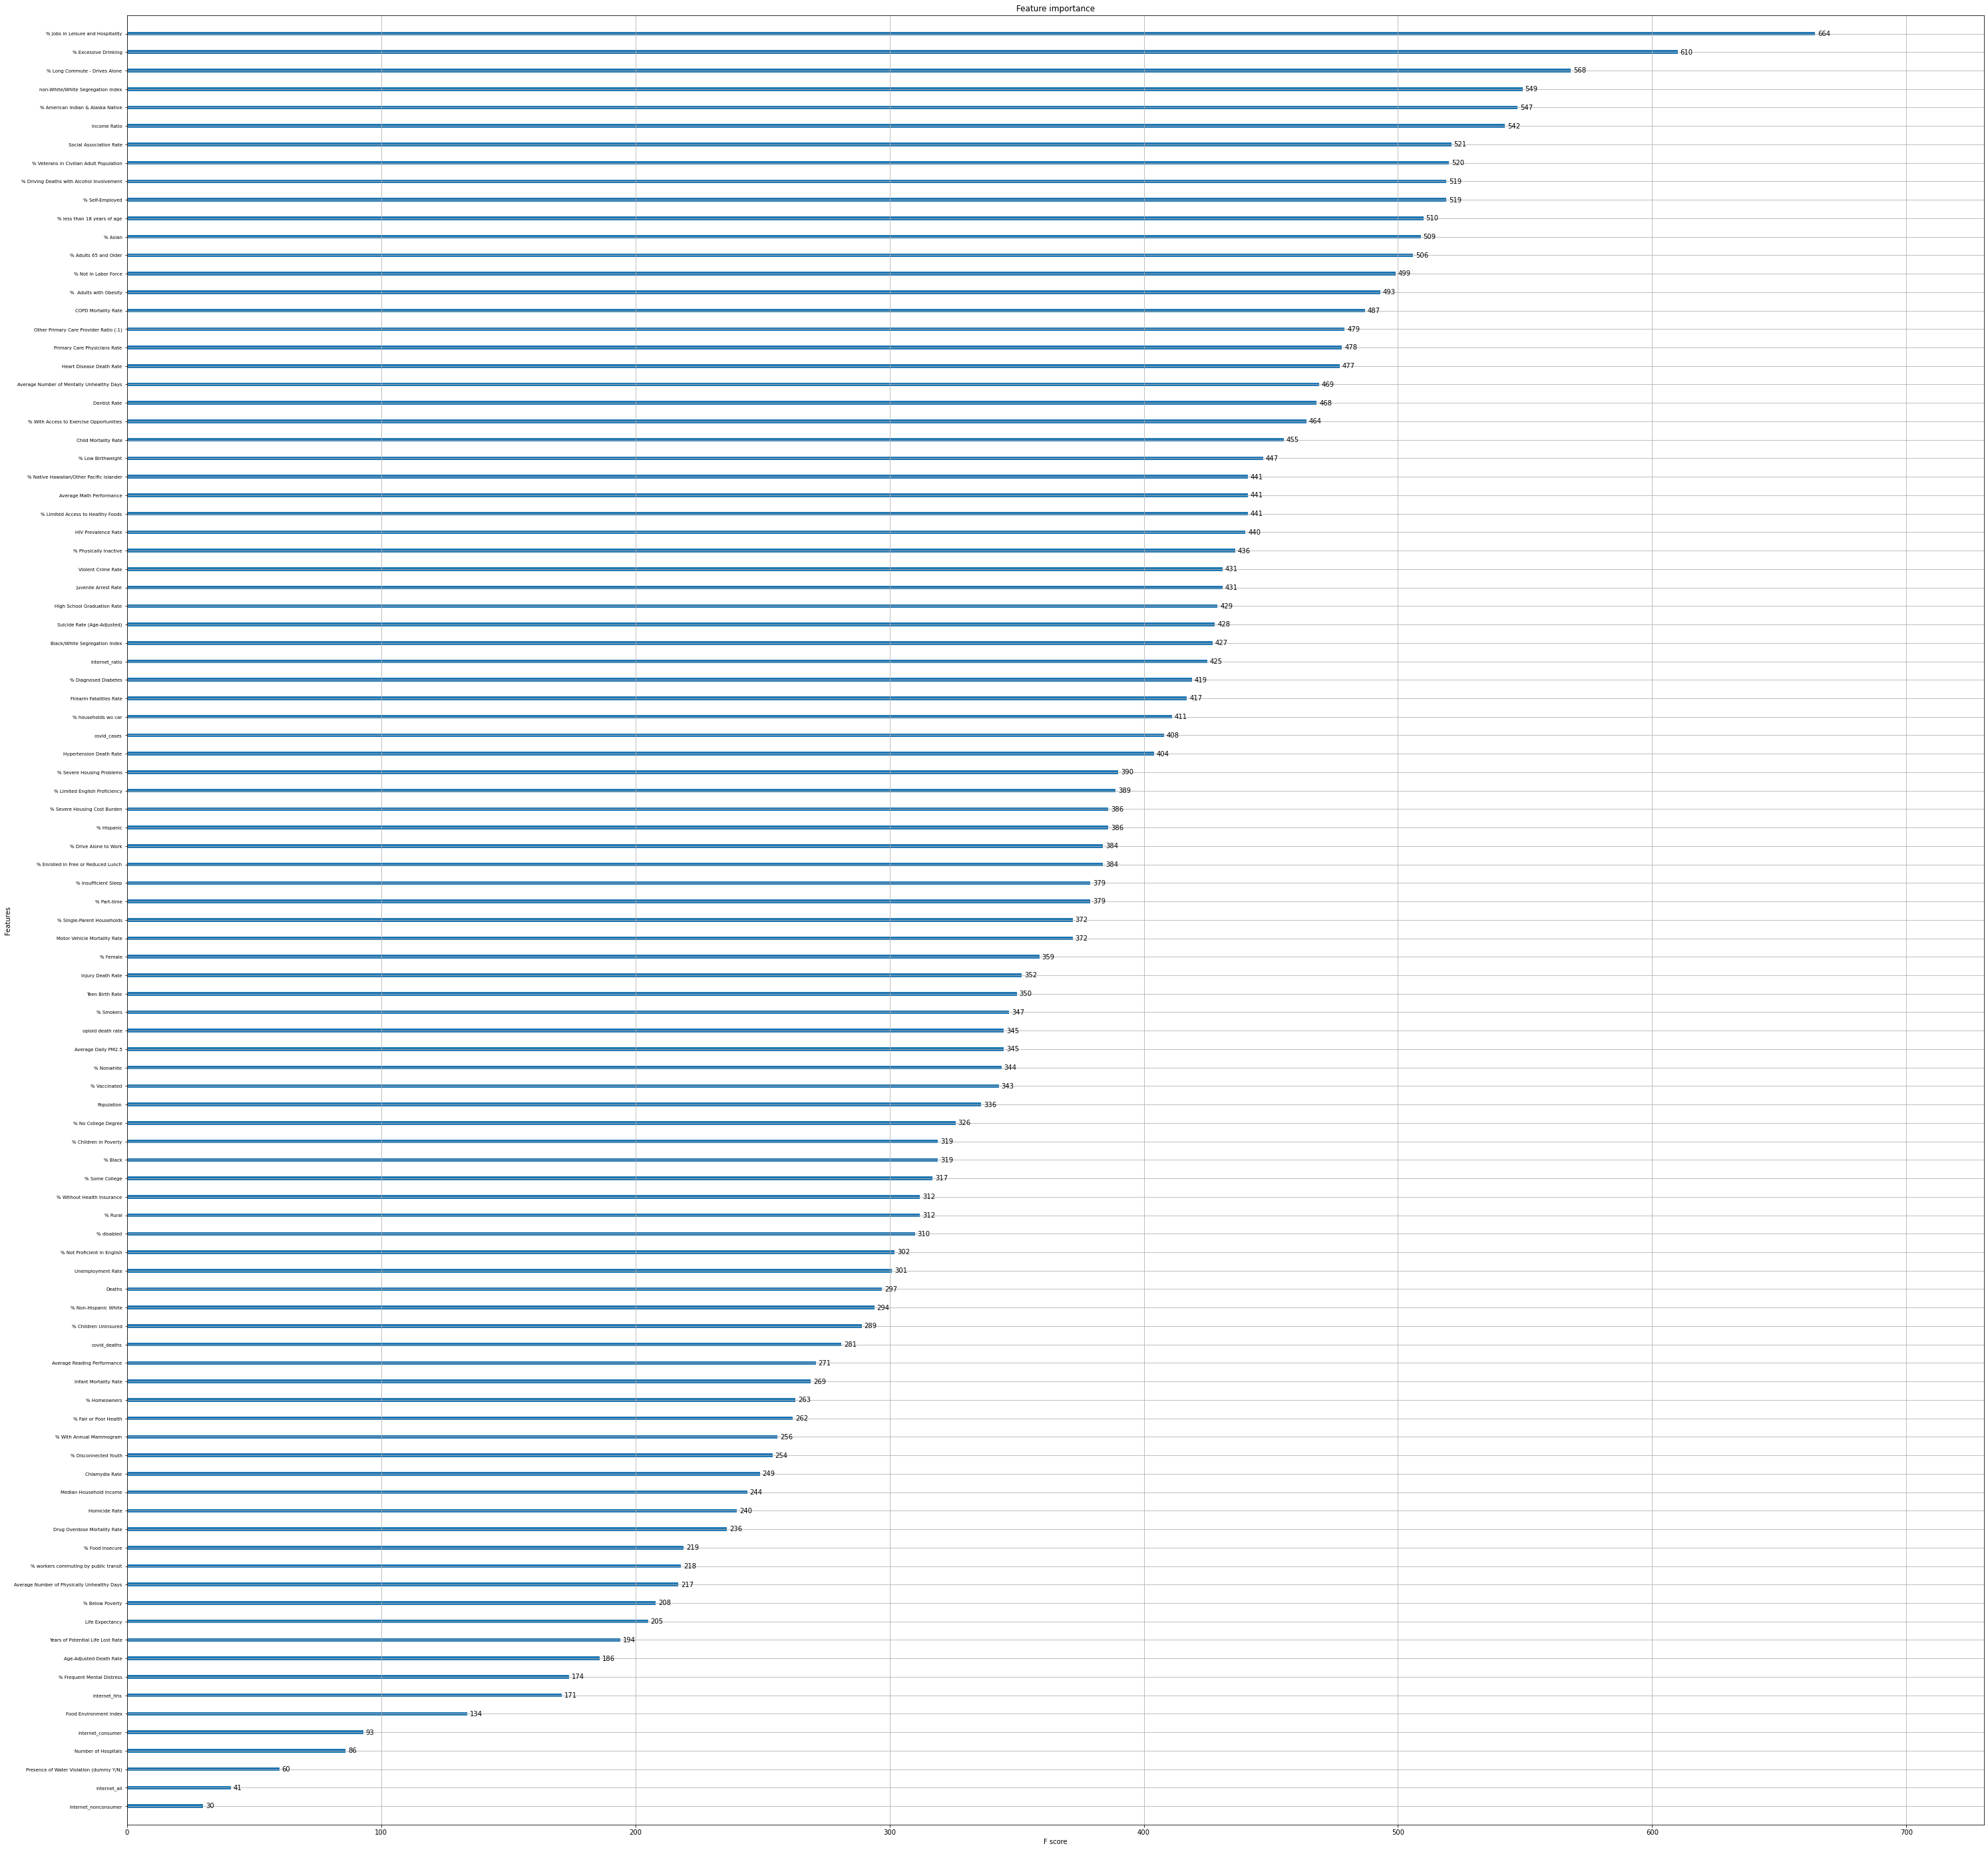

In [28]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [50, 50]
plt.yticks(size = 7)
plt.show()

### The following are the 10 most important features:
1. % Jobs in Leisure and Hospitality
2. % Excessive Drinking
3. % Long Commute - Drives Alone
4. non-White/White Segregation Index
5. % American Indian & Alaska Native
6. Income Ratio
7. Social Association Rate
8. % Veterans in Civilian Adult Population
9. % Driving Deaths with Alcohol Involvement
10. % Self-Employed

### Correlation

In [29]:
X_x = X.filter(['% Jobs in Leisure and Hospitality', '% Excessive Drinking', 
                '% Long Commute - Drives Alone', 'non-White/White Segregation Index', 
                '% American Indian & Alaska Native', 'Income Ratio', 'Social Association Rate',
                '% Veterans in Civilian Adult Population', 
                '% Driving Deaths with Alcohol Involvement', '% Self-Employed'])

In [30]:
Correlation_Matrix=X_x.corr().abs()
Correlation_Matrix

,% Jobs in Leisure and Hospitality,% Excessive Drinking,% Long Commute - Drives Alone,non-White/White Segregation Index,% American Indian & Alaska Native,Income Ratio,Social Association Rate,% Veterans in Civilian Adult Population,% Driving Deaths with Alcohol Involvement,% Self-Employed
% Jobs in Leisure and Hospitality,1.000000,0.060395,0.001801,0.080266,0.011033,0.051002,0.054627,0.169249,0.066387,0.311278
% Excessive Drinking,0.060395,1.000000,0.038178,0.039441,0.084710,0.223120,0.050098,0.064250,0.198663,0.061670
% Long Commute - Drives Alone,0.001801,0.038178,1.000000,0.078809,0.122663,0.071209,0.305281,0.021015,0.045295,0.056471
non-White/White Segregation Index,0.080266,0.039441,0.078809,1.000000,0.079944,0.198071,0.103861,0.162917,0.014847,0.226269
% American Indian & Alaska Native,0.011033,0.084710,0.122663,0.079944,1.000000,0.075588,0.078806,0.033915,0.091646,0.070813
Income Ratio,0.051002,0.223120,0.071209,0.198071,0.075588,1.000000,0.005735,0.304461,0.064637,0.142337
Social Association Rate,0.054627,0.050098,0.305281,0.103861,0.078806,0.005735,1.000000,0.022689,0.002168,0.046771
% Veterans in Civilian Adult Population,0.169249,0.064250,0.021015,0.162917,0.033915,0.304461,0.022689,1.000000,0.111622,0.148259
% Driving Deaths with Alcohol Involvement,0.066387,0.198663,0.045295,0.014847,0.091646,0.064637,0.002168,0.111622,1.000000,0.127904
% Self-Employed,0.311278,0.061670,0.056471,0.226269,0.070813,0.142337,0.046771,0.148259,0.127904,1.000000


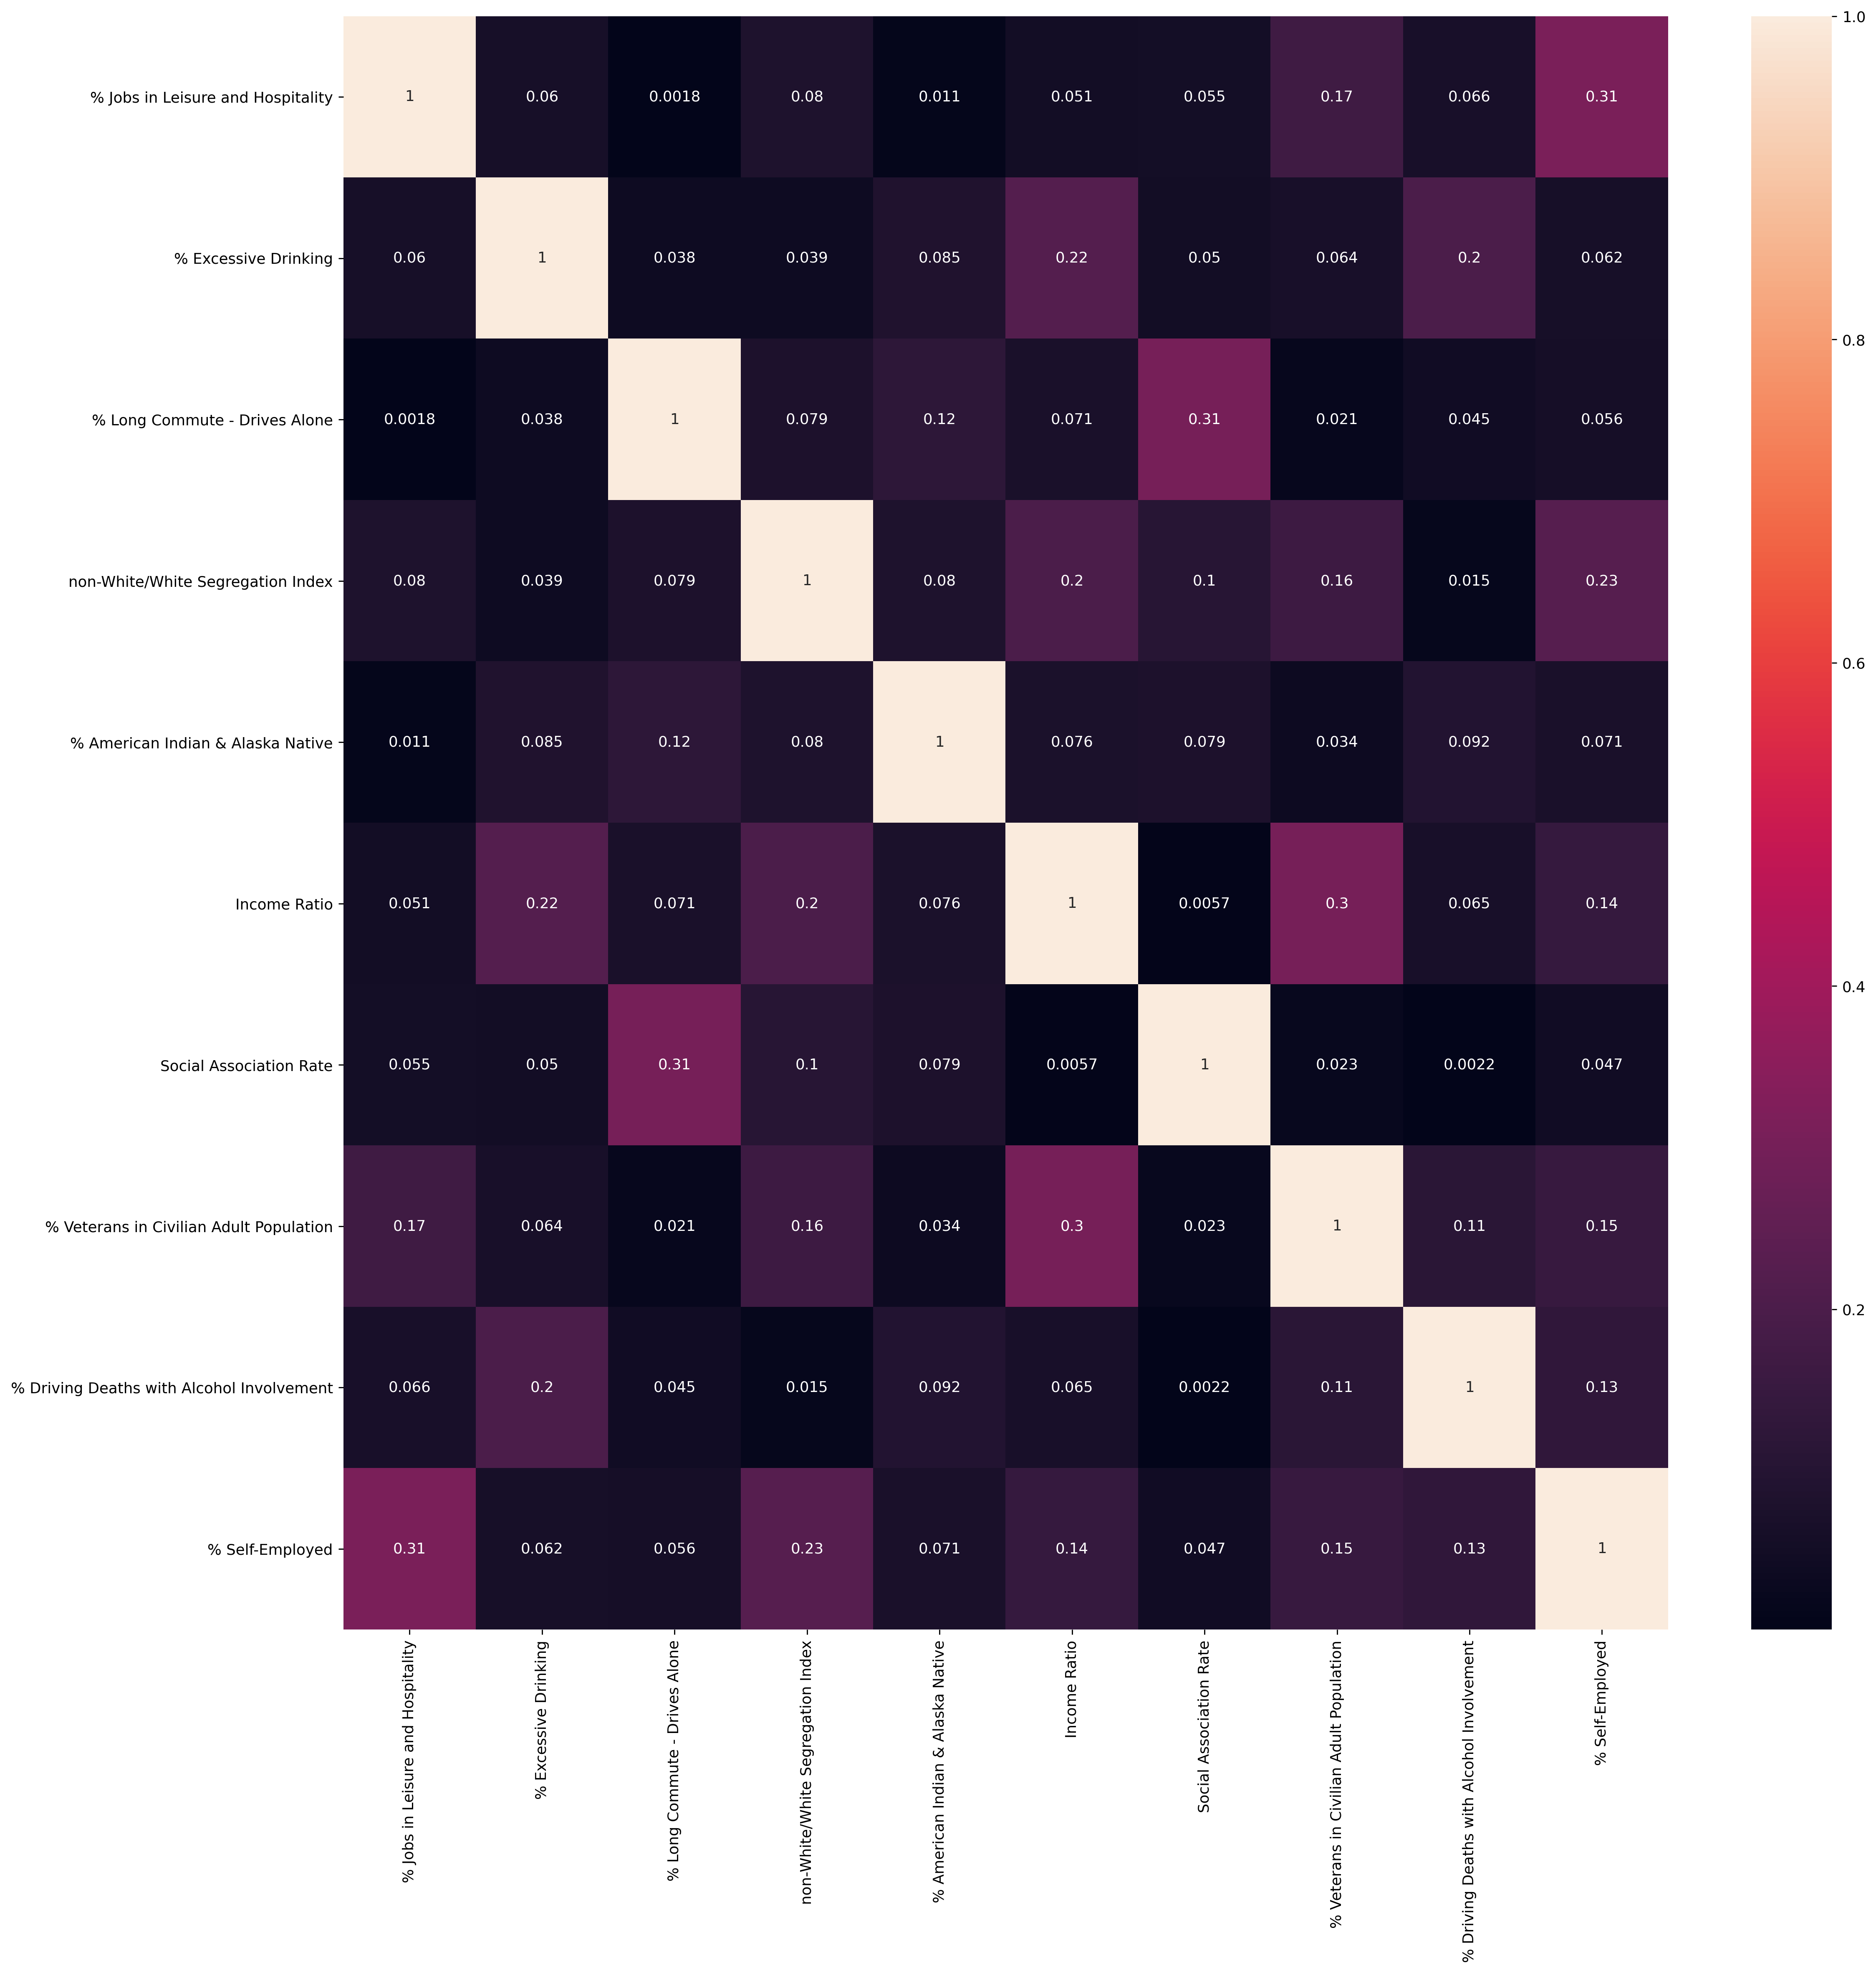

In [31]:
plt.figure(figsize=[20,20],dpi=256)
sns.heatmap(Correlation_Matrix, annot=True)

plt.show()

In [32]:
plt.figure(figsize=[20,20],dpi=400)
a = pps.matrix(X_x).pivot(columns='x', index='y', values='ppscore')
sns.heatmap(a, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.show()